## Assignment 1 (Edmunds)

### Team Members
#### Abigail Peck (ap69393)
#### Emily Caraher (ec45335)
#### Nandini Anand Kumar (na29337)
#### Riju Hariharan (rh42988)
#### Sarvesh Miskin (sm88728)
#### Varsha Ramesh (vr23656)

1. Write a web scraper using Python to fetch messages posted in Edmunds.com discussion forums. The scraper output should be a .csv file with the following columns: userid, date, and message (even though you will only use the messages in your analysis). Before you develop the scraper, carefully study one of the forums on Edmunds.com to understand the html design as well as the threading structures.

2. Fetch around 8,000-10,000 posts about cars from the Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedan. The idea is to have multiple brands and models being discussed without one of them being the focal point. Edmunds changed its forum structure a few years ago, but left the early posts with the old structure.block quotes should be discarded. In the scraper comment on the section that avoids this double- (or multi-counting) problem. You can start scraping from the earliest posts.

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time

BASE_URL = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
PAGE_URL_TEMPLATE = BASE_URL + "/p{page}"  # Page 1 = /discussion/... , Page 2+ = /p2, /p3 etc.

OUTPUT_FILE = "edmunds_entry_level_luxury_posts.csv"

def get_soup(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; EdmundsScraper/1.0)"
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return BeautifulSoup(response.text, "html.parser")

def parse_posts(soup, skip_original_post=False):
    posts_data = []

    comment_items = soup.find_all("li", class_="ItemComment")
    if not skip_original_post:
        # Include the very first post (original post at top of first page)
        op_container = soup.find("div", class_="ItemDiscussion")
        if op_container:
            posts_data.append(parse_single_post(op_container))

    for item in comment_items:
        posts_data.append(parse_single_post(item))

    return posts_data

def parse_single_post(container):
    # Username
    username_tag = container.find("a", class_="Username")
    userid = username_tag.get_text(strip=True) if username_tag else "Unknown"

    # Date
    date_tag = container.find("span", class_="DateCreated")
    date = date_tag.get_text(strip=True) if date_tag else "Unknown"

    # Message (excluding blockquotes)
    message_container = container.find("div", class_="Message")
    if not message_container:
        message = ""
    else:
        # Remove blockquotes or quoted content to avoid double-counting
        for quote in message_container.find_all(["blockquote", "div"], class_="Quote"):
            quote.decompose()  # remove the tag and its content

        message = message_container.get_text(separator="\n", strip=True)

    return (userid, date, message)

def scrape_forum(start_page=1, max_pages=100, target_posts=10000, delay=1.5):
    all_posts = []
    for page_num in range(start_page, max_pages + 1):
        url = BASE_URL if page_num == 1 else PAGE_URL_TEMPLATE.format(page=page_num)
        print(f"Fetching page {page_num} -> {url}")
        try:
            soup = get_soup(url)
            skip_op = (page_num != 1)
            posts = parse_posts(soup, skip_original_post=skip_op)
            if not posts:
                print("No more posts found. Ending scrape.")
                break
            all_posts.extend(posts)
            print(f"Total posts collected: {len(all_posts)}")

            if len(all_posts) >= target_posts:
                print("Target number of posts reached.")
                break
            time.sleep(delay)
        except Exception as e:
            print(f"Error on page {page_num}: {e}")
            break
    return all_posts[:target_posts]

def save_to_csv(posts, filename=OUTPUT_FILE):
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["userid", "date", "message"])
        writer.writerows(posts)
    print(f"Saved {len(posts)} posts to {filename}")

if __name__ == "__main__":
    posts = scrape_forum(start_page=1, max_pages=500, target_posts=10000, delay=1.2)
    save_to_csv(posts)

Fetching page 1 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans
Total posts collected: 51
Fetching page 2 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p2
Total posts collected: 101
Fetching page 3 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p3
Total posts collected: 151
Fetching page 4 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p4
Total posts collected: 201
Fetching page 5 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p5
Total posts collected: 251
Fetching page 6 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p6
Total posts collected: 301
Fetching page 7 -> https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p7
Total posts collected: 351
Fetching page 8 -> https

### Task A: 
Once you fetch the data, test if the data support Zipf’s law econometrically. Additionally plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

Zipf's Law Regression Results:
Estimated beta (should be ≈ 1): 1.6803
Intercept: 16.2414
R-squared: 0.9720


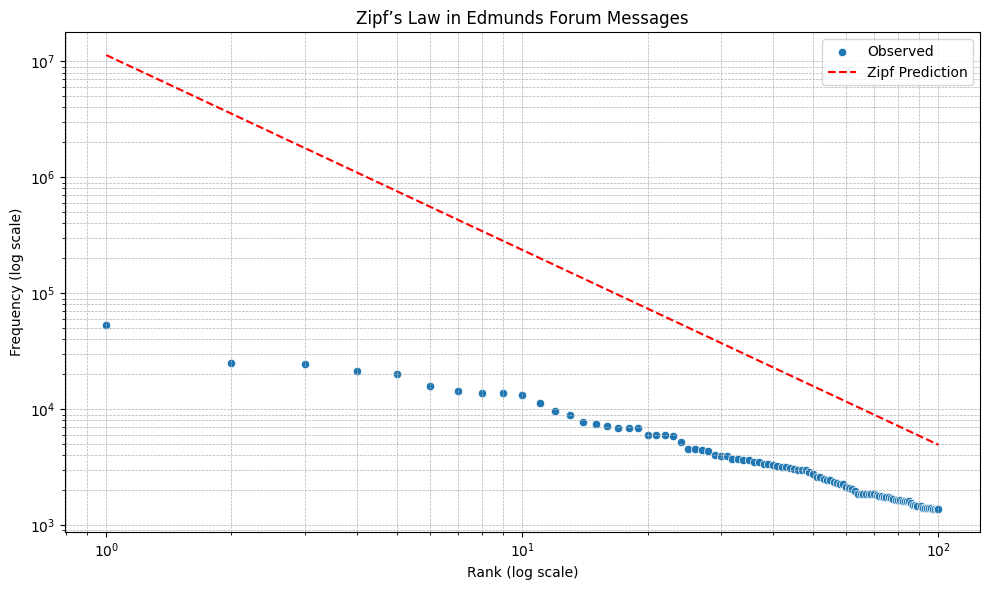

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter
from sklearn.linear_model import LinearRegression

# Load the dataset (from your scraper)
df = pd.read_csv("edmunds_entry_level_luxury_posts.csv")

# Concatenate all messages into one large string
all_text = " ".join(df["message"].astype(str))

# Tokenize: lowercase, keep only words (no punctuation), split by whitespace
tokens = re.findall(r'\b\w+\b', all_text.lower())

# Count word frequencies (do not remove stopwords or perform stemming)
word_counts = Counter(tokens)

# Create a dataframe sorted by frequency
freq_df = pd.DataFrame(word_counts.items(), columns=["word", "frequency"])
freq_df = freq_df.sort_values(by="frequency", ascending=False).reset_index(drop=True)
freq_df["rank"] = freq_df["frequency"].rank(method="min", ascending=False).astype(int)

# Take log(rank) and log(frequency)
freq_df["log_rank"] = np.log(freq_df["rank"])
freq_df["log_freq"] = np.log(freq_df["frequency"])

# Econometric Test: Regress log(frequency) on log(rank)
X = freq_df["log_rank"].values.reshape(-1, 1)
y = freq_df["log_freq"].values
model = LinearRegression()
model.fit(X, y)

beta = -model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)

print(f"Zipf's Law Regression Results:")
print(f"Estimated beta (should be ≈ 1): {beta:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Plot top 100 words against Zipf's prediction
top100 = freq_df.head(100)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="rank", y="frequency", data=top100, label="Observed")

# Plot theoretical Zipf prediction: frequency = C / rank^beta
C = np.exp(intercept)
zipf_prediction = C / top100["rank"] ** beta
plt.plot(top100["rank"], zipf_prediction, color='red', linestyle='--', label="Zipf Prediction")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Zipf’s Law in Edmunds Forum Messages")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

### Task B: 
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive, also contains some errors, but it does not matter!) are provided in a separate file. Remember, in NLP you will never get 100% accuracy in anything you do, and yet the results are generally much richer than what you would ever get with numeric data! Even if a brand (e.g., BMW) is mentioned multiple times in a message, it should be counted as 1.

In [3]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)

# Load brand + model dataset
brand_model_df = pd.read_csv("car_models_and_brands.csv")
brand_model_df['brand'] = brand_model_df['Brand'].str.lower()
brand_model_df['model'] = brand_model_df['Model'].str.lower()

# Map models to brands
model_to_brand = dict(zip(brand_model_df['model'], brand_model_df['brand']))

# Create regex pattern that matches any model
model_pattern = r'\b(' + '|'.join(re.escape(model) for model in model_to_brand.keys()) + r')\b'

# Precompute all brands and initialize brand_counts once
all_brands = set(brand_model_df['brand'].unique())
brand_counts = Counter()

# Replace model with brand
def replace_model_with_brand(match):
    model = match.group(0)
    return model_to_brand.get(model, model)  # replace model by brand

# Step 2: get brand counts (all brands)
for msg in df['message'].astype(str):
    msg_lower = msg.lower()
    # Replace all models in one go
    msg_replaced = re.sub(model_pattern, replace_model_with_brand, msg_lower)
    tokens = re.findall(r'\b\w+\b', msg_replaced)
    filtered = [w for w in tokens if w not in stop_words]
    brands_in_msg = set(w for w in filtered if w in all_brands)
    for b in brands_in_msg:
        brand_counts[b] += 1

# Step 3: Get top 10 brands
valid_top_brands = [
    (b, c) for b, c in brand_counts.most_common()
    if b in all_brands and b not in {'car', 'sedan', 'seat', 'problem'}
]

# Take top 10 after filtering
top_10_brands = [b for b, _ in valid_top_brands[:10]]
top_10_brands_set = set(top_10_brands)

print("Top 10 Brands:")
for b in top_10_brands:
    print(f"{b}: {brand_counts[b]}")

Top 10 Brands:
bmw: 3285
acura: 993
audi: 985
honda: 814
infiniti: 733
toyota: 679
mercedes: 470
nissan: 457
cadillac: 356
volvo: 329


### Task C: 
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task).

In [4]:
from itertools import combinations
import pandas as pd

# Create a list of brand sets for each message (only keeping top 10 brands)
message_brand_sets = []

for msg in df['message'].astype(str):
    msg_lower = msg.lower()
    msg_replaced = re.sub(model_pattern, replace_model_with_brand, msg_lower)
    tokens = re.findall(r'\b\w+\b', msg_replaced)
    filtered = [w for w in tokens if w not in stop_words]
    brands_in_msg = set(w for w in filtered if w in top_10_brands_set)
    message_brand_sets.append(brands_in_msg)

# Total number of messages
N = len(message_brand_sets)

# Initialize counts
co_occurrence_counts = Counter()
individual_counts = Counter()

# Count occurrences
for brand_set in message_brand_sets:
    for brand in brand_set:
        individual_counts[brand] += 1
    for brand_pair in combinations(sorted(brand_set), 2):  # sorted to avoid (b,a) and (a,b)
        co_occurrence_counts[brand_pair] += 1

# Compute lift ratios
lift_data = []

for (brand1, brand2), joint_count in co_occurrence_counts.items():
    p_a = individual_counts[brand1] / N
    p_b = individual_counts[brand2] / N
    p_ab = joint_count / N
    lift = p_ab / (p_a * p_b) if (p_a * p_b) > 0 else 0
    lift_data.append({
        'Brand A': brand1,
        'Brand B': brand2,
        'P(A)': round(p_a, 4),
        'P(B)': round(p_b, 4),
        'P(A and B)': round(p_ab, 4),
        'Lift': round(lift, 4)
    })

# Convert to DataFrame for easier viewing
lift_df = pd.DataFrame(lift_data)
lift_df = lift_df.sort_values(by='Lift', ascending=False).reset_index(drop=True)

# Show top 15 lifts
print("Top Lift Ratios Between Top 10 Brands:")
print(lift_df.head())

Top Lift Ratios Between Top 10 Brands:
    Brand A   Brand B    P(A)    P(B)  P(A and B)    Lift
0  mercedes     volvo  0.0470  0.0329      0.0077  4.9796
1  cadillac  mercedes  0.0356  0.0470      0.0074  4.4227
2     honda    toyota  0.0814  0.0679      0.0225  4.0709
3     honda    nissan  0.0814  0.0457      0.0143  3.8441
4    nissan    toyota  0.0457  0.0679      0.0118  3.8027


### Task D: 
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub).

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


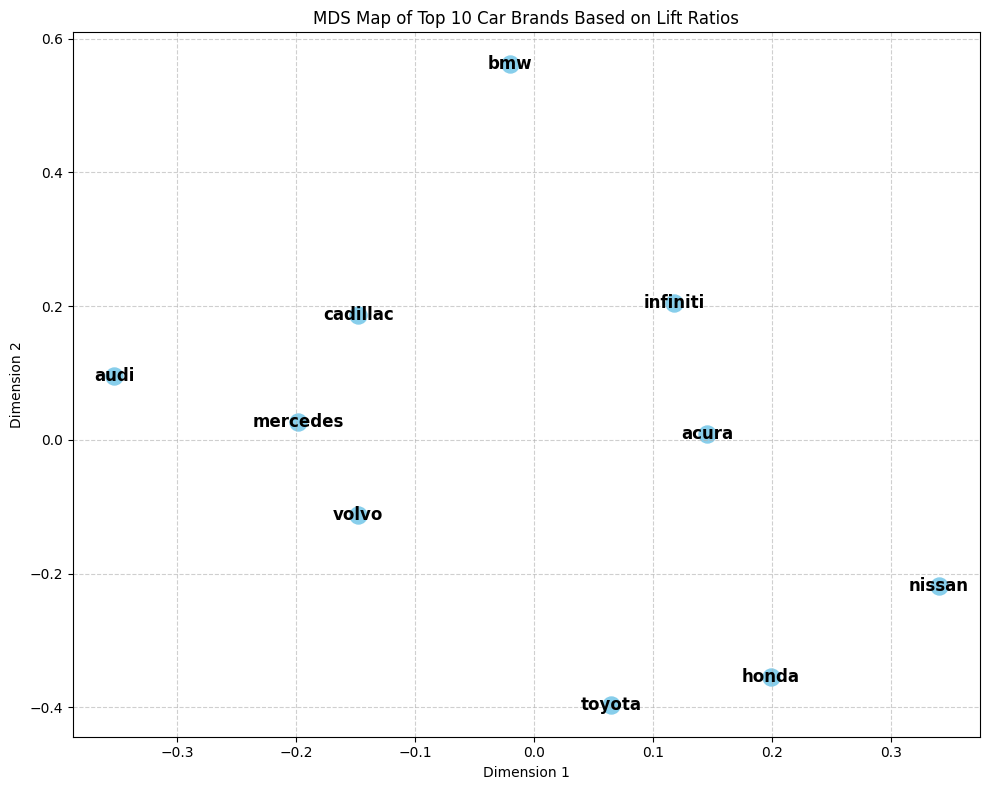

In [5]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

brands = sorted(top_10_brands)
brand_index = {brand: i for i, brand in enumerate(brands)}

# Initialize distance matrix with zeros
distance_matrix = np.zeros((len(brands), len(brands)))

# Fill distance matrix using lift values (lower distance for higher lift)
# If no lift value for a pair (like diagonals or missing), set distance to 1 (max distance)
for i, brand1 in enumerate(brands):
    for j, brand2 in enumerate(brands):
        if i == j:
            distance_matrix[i, j] = 0  # zero distance to self
        elif i < j:
            # Find lift value for pair (brand1, brand2)
            pair = tuple(sorted([brand1, brand2]))
            lift_row = lift_df[
                ((lift_df['Brand A'].str.lower() == pair[0]) & (lift_df['Brand B'].str.lower() == pair[1]))
            ]
            if not lift_row.empty:
                lift_val = lift_row['Lift'].values[0]
                # Convert lift to distance: higher lift = closer (lower distance)
                distance = 1 / lift_val if lift_val > 0 else 1
            else:
                distance = 1  # no lift info → max distance
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # symmetric matrix

# Apply MDS on distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=150, color='skyblue')

for i, brand in enumerate(brands):
    plt.text(coords[i, 0], coords[i, 1], brand, fontsize=12,
             ha='center', va='center', fontweight='bold')

plt.title('MDS Map of Top 10 Car Brands Based on Lift Ratios')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Task E: 
What insights can you offer to your client – who is interested in the overall auto industry -- from your analyses in Tasks C and D?

Based on our analysis of social media conversations, it is clear that BMW, Audi, and Mercedes dominate the entry-level luxury market, with high lift values showing they are frequently cross-shopped and viewed as direct substitutes. The MDS map reinforces this, placing the German trio tightly together in consumers’ minds. Lexus, while still a strong contender, is positioned slightly apart, reflecting its differentiation around comfort and reliability rather than pure performance. Volvo sits further on the periphery, emphasizing its distinct safety-focused identity, while Acura and Infiniti appear less frequently in consideration, suggesting weaker competitive presence. For executives, this means the German brands must focus on sharper differentiation to win within their intense rivalry, Japanese brands should highlight unique strengths such as reliability and hybrid technology to avoid head-on competition, and niche players like Volvo should continue reinforcing their distinct brand values to maintain loyal customer segments.

### Task F: 
What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS plot for this question.

In [6]:
all_text = " ".join(df['message'].astype(str).str.lower())

# Tokenize: only words with alphabets
tokens = re.findall(r'\b[a-z]+\b', all_text)

# Remove stopwords only
filtered_tokens = [w for w in tokens if w not in stop_words]

# Count word frequencies
word_counts = Counter(filtered_tokens)

# Convert to DataFrame and sort by frequency
freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

print(freq_df.head(60))


           word  frequency
0             s       8992
1           car       7497
2             t       7196
3           bmw       4353
4          cars       3713
5          like       3639
6          just       3072
7            tl       2968
8           don       2460
9         think       2281
10            m       2141
11       series       1963
12  performance       1868
13       better       1864
14        drive       1856
15          new       1841
16        lexus       1742
17       luxury       1677
18          cts       1651
19         good       1621
20       people       1613
21        sedan       1485
22      driving       1464
23         know       1464
24       really       1417
25         want       1398
26         best       1372
27        price       1293
28            d       1283
29           ve       1219
30         time       1217
31     interior       1194
32         does       1180
33         make       1175
34          way       1173
35          say       1173
3

In [7]:
top_5_attributes = ['performance', 'luxury', 'drive', 'interior', 'sport']

In [8]:
from collections import Counter

# Initialize: attribute-to-brand counter
attribute_brand_counts = {attr: Counter() for attr in top_5_attributes}

for msg in df['message'].astype(str):
    msg_lower = msg.lower()
    # Replace all car models with their brands
    msg_replaced = re.sub(model_pattern, replace_model_with_brand, msg_lower)

    # Tokenize and remove stopwords
    tokens = re.findall(r'\b\w+\b', msg_replaced)
    filtered_tokens = [t for t in tokens if t not in stop_words]

    # Find which brands and attributes appear in the message
    brands_in_msg = set(w for w in filtered_tokens if w in top_10_brands_set)
    attrs_in_msg = set(w for w in filtered_tokens if w in top_5_attributes)

    # Count associations
    for attr in attrs_in_msg:
        for brand in brands_in_msg:
            attribute_brand_counts[attr][brand] += 1

print("\nMost Associated Brands for Each Top Attribute:\n")
for attr in top_5_attributes:
    most_common = attribute_brand_counts[attr].most_common(3)
    print(f"{attr.title()}:")
    for brand, count in most_common:
        print(f"   {brand.title()} — {count} messages")



Most Associated Brands for Each Top Attribute:

Performance:
   Bmw — 640 messages
   Acura — 204 messages
   Audi — 183 messages
Luxury:
   Bmw — 504 messages
   Acura — 215 messages
   Toyota — 184 messages
Drive:
   Bmw — 617 messages
   Audi — 226 messages
   Acura — 206 messages
Interior:
   Bmw — 336 messages
   Audi — 177 messages
   Acura — 124 messages
Sport:
   Bmw — 332 messages
   Audi — 111 messages
   Acura — 107 messages


### Task G: 
What advice will you give to your client from Task F?

My first piece of advice is JD needs to understand the categories these top five features fall into. Luxury and interior are experience features, while performance, drive and manual are all technical features. It is important to note this distinction because you need to be able to highlight both categories well. You cannot just show a video of a car driving because you won’t be showing off the luxury or interior element. And the opposite is also true, you also cannot just show a video of the interior of the car. Customers have proven through social media analysis, they care about both experience and technical features. You will receive the most attention and customer interest by carefully highlighting these features individually.

My next piece of advice is to understand the current top competitors and find the weaknesses they may have. The current top competitors are BMW, Audi, and Acura. These companies are in the top three mentions of each attribute, excluding luxury. It is clear they have cornered the market on entry level luxury cars. I would recommend that JD looks at each of the companies more closely to determine what marketing tactics they use. Looking at what tactics each company uses will reveal insights about what they don’t do. What is missing from their promotions that JD could fill in the market gap with?

My last piece of advice is to use these top companies as a comparison. A new company trying to break into the market could make themselves more relevant by drawing explicit comparisons between themselves and these top three companies. This would create conversations around the new company and it could draw attention from current BMW, Audi, or Acura purchasers. I believe to break into the entry level luxury car market, you need to act like a luxury car company. You shouldn’t compare yourself to Ford or Honda, because that’s not where you want to be. You cannot wait for customers to put yourself in the conversation, you need to be able to put yourself in the conversation. This proactive approach will allow a new company to control the narrative around their car brand.


### Task H: 
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [9]:
import re, pandas as pd
from collections import defaultdict

MESSAGES_CSV = "edmunds_entry_level_luxury_posts.csv"  #The csv file with the scrapped reviews.
ASP_CSV = 'aspiration.csv' #The CSV file containing the aspirational words.

# Load data
msgs = (pd.read_csv(MESSAGES_CSV, usecols=["message"])["message"]
          .fillna("").astype(str).str.lower().tolist())
N = len(msgs)

brands = [(b[0] if isinstance(b, tuple) else b) for b in top_10_brands]
brands = [str(b).strip().lower() for b in brands if str(b).strip()]
# Canonicalization to merge obvious variants
def canon_brand(b):
    if b in {"mercedes-benz","mercedes benz","benz","mb"}: return "mercedes"
    if b == "vw": return "volkswagen"
    return b
brands = list(dict.fromkeys([canon_brand(b) for b in brands]))

# whole-word brand regex
def ww(name): return re.compile(rf"(?<![A-Za-z0-9]){re.escape(name)}(?![A-Za-z0-9])", re.I)
brand_rx = {b: ww(b) for b in brands}

# Load aspiration phrases & upgrade to anchored regex n-grams
# Read aspiration.csv
raw = (pd.read_csv(ASP_CSV, header=None)[0]
         .dropna().astype(str).str.lower().str.strip().tolist())


# Rules to turn vague seeds into purchase/ownership intent phrases
UPGRADES = {
    r"\bwould love\b": r"\bwould love to (?:buy|get|own|drive)\b",
    r"\bwould like\b": r"\bwould like to (?:buy|get|own|test drive|drive)\b",
    r"\bi want\b":     r"\bi (?:really )?want to (?:buy|get|own)\b",
    r"\bwant\b":       r"\bi (?:really )?want to (?:buy|get|own)\b",
    r"\bconsider(?:ing)?\b": r"\bconsider(?:ing)? (?:buying|get(?:ting)?|leasing)\b",
    r"\blooking to\b": r"\blooking to (?:buy|get|own|lease)\b",
    r"\bgoing to buy\b": r"\bgoing to buy\b",
    r"\bthinking of buying\b": r"\bthinking of buying\b",
    r"\blove\b": None,
}

# Shopping intent phrases
KEEP = [
    r"\btest driv(?:e|ed|ing)\b",
    r"\border(?:ed|ing)?\b", r"\bdeposit\b", r"\bdown payment\b",
    r"\bdelivery\b", r"\btook delivery\b", r"\bpick(?:ed)? up\b",
    r"\btrade[-\s]?in\b", r"\breserv(?:e|ed|ing)\b",
    r"\blease(?:d|ing)?\b", r"\bfinanc(?:e|ed|ing)\b",
    r"\bpayment\b", r"\bmsrp\b", r"\bquote\b", r"\bdeal\b",
    r"\b(out the door|o\.?t\.?d)\b",
    r"\b(money factor|\bmf\b)\b", r"\bresidual\b", r"\bapr\b"
]

def upgrade_phrase(p):
    # if phrase matches a key in UPGRADES, return its anchored version or None to drop
    for k, v in UPGRADES.items():
        if re.fullmatch(k, p):
            return v
    # otherwise keep literal phrase as-is, escaped
    return re.escape(p)

# Build final intent regex list
intent_patterns = []
for p in raw:
    p = p.strip()
    if not p:
        continue
    up = upgrade_phrase(p)
    if up: intent_patterns.append(re.compile(up, re.I))

# Add precise keepers
intent_patterns += [re.compile(rx, re.I) for rx in KEEP]

# Scan messages once (binary per message)
n_brand  = defaultdict(int)   # n_b
n_intent = 0                  # n_I
n_bI     = defaultdict(int)   # n_{b ∧ I}

for t in msgs:
    has_int = any(rx.search(t) for rx in intent_patterns)
    if has_int:
        n_intent += 1
    present = {b for b, rx in brand_rx.items() if rx.search(t)}  # 1 per brand/msg
    for b in present:
        n_brand[b] += 1
        if has_int:
            n_bI[b] += 1

# Calculate Lift(brand, intent) and ranking
rows = []
for b in brands:
    nb, nbI = n_brand[b], n_bI[b]
    lift = (nbI * N) / (nb * n_intent) if (nb and n_intent) else 0.0
    rows.append({"brand": b, "messages_with_brand": nb,
                 "messages_with_intent": n_intent,
                 "brand_and_intent": nbI,
                 "lift_to_intent": round(lift, 3)})

res = pd.DataFrame(rows).sort_values(["lift_to_intent","messages_with_brand"],
                                     ascending=[False, False])
res



,brand,messages_with_brand,messages_with_intent,brand_and_intent,lift_to_intent
6,mercedes,333,3091,153,1.486
2,audi,649,3091,290,1.446
0,bmw,2532,3091,1124,1.436
4,infiniti,642,3091,283,1.426
1,acura,761,3091,326,1.386
9,volvo,282,3091,118,1.354
8,cadillac,347,3091,145,1.352
7,nissan,268,3091,111,1.340
3,honda,356,3091,144,1.309
5,toyota,244,3091,91,1.207


We analyzed the top 10 brands that had aspirational intent in the reviews. We selected the aspirational words such as 'would love to', 'want to', 'dream car', etc to shortlist the reviews which had the intent. After filtering the reviews, we calculated the lift between the brand and the number of intent messages to arrive with the aspirational brand.

As a general audience, one might naturally expect *BMW* to emerge as the top aspirational brand given its reputation for performance and status. However, the analysis revealed an “aha moment”: it was actually **Mercedes** that stood out as the most aspirational brand.

Based on the lift analysis, Mercedes appears to be the most aspirational brand among the top 10 in this dataset, with the highest lift ratio to aspirational intent messages (1.486). This suggests that when people express intent to buy or own a car, Mercedes is mentioned disproportionately more often compared to its overall frequency in the messages. Audi and BMW also show high aspiration, but Mercedes leads.

**Business implications for Mercedes:**

1.  **Leverage Aspiration in Marketing:** Mercedes should highlight the aspirational aspect of their brand in marketing campaigns. Emphasize the dream of owning a Mercedes and how it represents achievement or a desired lifestyle.
2.  **Target Potential Buyers:** Since Mercedes is associated with purchase intent, marketing efforts should focus on individuals who are actively considering buying a luxury vehicle. This could involve targeted advertising, special offers, and streamlined purchasing experiences.
3.  **Maintain Brand Image:** The high aspiration is tied to Mercedes' brand image of luxury, performance, and prestige. They must continue to invest in maintaining this image through product innovation, quality, and exclusive customer experiences.
4.  **Capitalize on Cross-Shopping:** While aspirational, the brand is still discussed alongside BMW and Audi. Mercedes can use this to their advantage by highlighting their unique aspirational qualities compared to competitors, potentially converting individuals considering other German luxury brands.
5. **Acknowledge Key Competitors:** The MDS map indicates that key competitors for Mercedes in this forum are Cadillac, Volvo, and Audi. Marketing should consider strategies to differentiate from or directly address these brands.
6. **Highlight Performance and Sport Attributes:** The analysis shows that users strongly associate Mercedes with performance, engine quality, and being a sports sedan. Mercedes marketing should continue to emphasize these technical attributes, as they are clearly important to the target audience in this forum.